In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
DATA_DIR = 'D:/Datasets/ml-latest/'

In [3]:
df = pd.read_csv(DATA_DIR + 'tags.csv')

In [4]:
df.head()

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


In [5]:
# Создаем spark сессию
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder
    .config('spark.driver.memory', '8G')
    .config('spark.sql.analyzer.failAmbiguousSelfJoin', 'False')
    .master("local[*]")
    .getOrCreate()
)

In [6]:
# считываем данные из CSV
# и преобразуем времяпроставления оценки из целого числа в дату мл временем
import os
import pyspark.sql.functions as sql_func

movies = (
    spark
    .read
    .csv(
        os.path.join(DATA_DIR, 'movies.csv'),
        header=True,
        inferSchema=True
    )
    # если используется меньше памяти,
    # то здесь можно взять не все данные, а небольшую выборку
    # даже при fraction=.01 качественная картина не меняеся
    .withColumn('genres_list', sql_func.split('genres', '\|'))
    .select('movieId', 'title', 'genres_list')
    .cache()
)

In [7]:
movies.limit(10).toPandas()

,movieId,title,genres_list
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
5,6,Heat (1995),"[Action, Crime, Thriller]"
6,7,Sabrina (1995),"[Comedy, Romance]"
7,8,Tom and Huck (1995),"[Adventure, Children]"
8,9,Sudden Death (1995),[Action]
9,10,GoldenEye (1995),"[Action, Adventure, Thriller]"


In [8]:
# Сначала посмотрим на общее распределение тегов
raw_tags = (
    spark
    .read
    .csv(
        os.path.join(DATA_DIR, 'tags.csv'),
        header=True,
        inferSchema=True
    )
    .cache()
)

In [9]:
# Протегировано чуть более половины фильмов

movie_tag_count = raw_tags.count()
tag_count = raw_tags.select('tag').distinct().count()
movie_count = raw_tags.select('movieId').distinct().count()
print('фильмов всего:', movies.select('movieId').distinct().count())
print('фильмов с тегом:', movie_count)
print('различных тегов:', movie_tag_count)
print('всего соотвествий фильм-тег', movie_tag_count)
print('доля не нулефвых элементов фильм-тег:',
      movie_tag_count / movie_count / tag_count)

фильмов всего: 58098
фильмов с тегом: 45981
различных тегов: 1108997
всего соотвествий фильм-тег 1108997
доля не нулефвых элементов фильм-тег: 0.00032280790285891604


In [10]:
# некоторые теги различаются только регистром
print(
    "различных тегов без учета регистра:",
    raw_tags.select(sql_func.upper(sql_func.col('tag'))).distinct().count()
)

различных тегов без учета регистра: 66980


In [11]:
# нас ек будет интересовать, какой именно пользователь поставил тег и когда это произошло
tags = (
    raw_tags
    # теги могут различатьтся только регистром
    # поэтому приведём их все к верхнему
    .select(
        sql_func.col("movieId"),
        sql_func.upper(sql_func.col("tag")).alias("tag")
    )
    .groupBy("movieId")
    .agg(sql_func.collect_list("tag").alias("tags_list"))
    .join(movies, "movieId", "right")
    .cache()
)

In [12]:
tags.limit(10).toPandas()

,movieId,tags_list,title,genres_list
0,148,"[NUDITY (TOPLESS), CATCHY, NUDITY (TOPLESS - N...","Awfully Big Adventure, An (1995)",[Drama]
1,463,None,Guilty as Sin (1993),"[Crime, Drama, Thriller]"
2,471,"[NO IDEA, VHS, BUSINESS, BUSINESS IS THE ANTAG...","Hudsucker Proxy, The (1994)",[Comedy]
3,496,"[LONELINESS, SUNDANCE AWARD WINNER, SUNDANCE G...",What Happened Was... (1994),"[Comedy, Drama, Romance, Thriller]"
4,833,"[ZAZ, SPOOF, HART BOCHNER, COMEDY, HIGH SCHOOL...",High School High (1996),[Comedy]
5,1088,"[NOT VERY GOOD, DANCING, CHEESY, PATRICK SWAYZ...",Dirty Dancing (1987),"[Drama, Musical, Romance]"
6,1238,"[BURT LANCASTER, DENIS LAWSON, FULTON MCKAY, N...",Local Hero (1983),[Comedy]
7,1342,"[HORROR, SLASHER, NUDITY (TOPLESS), HORROR, BE...",Candyman (1992),"[Horror, Thriller]"
8,1580,"[OSCAR WINNER, PLOT TWIST, SCI-FI, CONSPIRACY ...",Men in Black (a.k.a. MIB) (1997),"[Action, Comedy, Sci-Fi]"
9,1591,"[COMIC BOOK, COMIC BOOK, SUPER HERO, COMIC BOO...",Spawn (1997),"[Action, Adventure, Sci-Fi, Thriller]"


In [13]:
# Можно создать такое представление и выполнять запросы на обычном sql
raw_tags.createOrReplaceTempView("raw_tags")

spark.sql("""
    SELECT 
        COLLECT_LIST(tag),
        movieId
    FROM raw_tags
    GROUP BY movieId 
""").limit(10).toPandas()

,collect_list(tag),movieId
0,"[nudity (topless), catchy, Nudity (Topless - N...",148
1,"[no idea, VHS, business, business is the antag...",471
2,"[loneliness, Sundance award winner, Sundance G...",496
3,"[ZAZ, spoof, Hart Bochner, comedy, high school...",833
4,"[not very good, dancing, cheesy, Patrick Swayz...",1088
5,"[Burt Lancaster, Denis Lawson, Fulton McKay, N...",1238
6,"[Horror, slasher, nudity (topless), Horror, Be...",1342
7,"[Oscar Winner, plot twist, sci-fi, conspiracy ...",1580
8,"[comic book, comic book, super hero, comic boo...",1591
9,"[lawyers, psychological, temptation, incest, N...",1645


In [14]:
# объединим теги и жанры в единое пространство текстовых фич
from pyspark.sql.types import ArrayType, StringType

# В Spark нет некоторых полезных функций, но легко можно создать свои (UDF - user defined function)
#  в часности, мы хотим провести все жанры также к верхнему регистру
list_concat = sql_func.udf(
    lambda one_list, another_list:
        [str.upper(elem) for elem in one_list] + (another_list if another_list else []),
    returnType=ArrayType(StringType())
)

content_features = (
    tags
    .select(
        "movieId",
        "title",
        list_concat("genres_list", "tags_list").alias("content_features")
    )
    .cache()
)

In [15]:
# например, Гарри Потер и философский камень
content_features.where("movieId == 4896").toPandas()

,movieId,title,content_features
0,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,"[ADVENTURE, CHILDREN, FANTASY, HARRY POTTER, H..."


In [16]:
# мешок слов (bags-of-words)
from pyspark.sql.functions import explode, count, desc

(
    content_features
    .where("movieId == 4896")
    .select(explode("content_features").alias("words"))
    .groupBy("words")
    .agg(count("words").alias("freq"))
    .orderBy(desc("freq"))
    .toPandas()
)

,words,freq
0,MAGIC,73
1,FANTASY,64
2,HARRY POTTER,41
3,WIZARDS,40
4,BASED ON A BOOK,38
...,...,...
112,WITCHES,1
113,TROLLS,1
114,ERLEND'S DVDS,1
115,CHILDHOOD MEMORY,1


In [17]:
# такие же фичи у нас есть для всех фильмов
content_features.count()

58098

In [18]:
# посчитаем частоты встречаемости для тегов для всех фильмов
from pyspark.ml.feature import HashingTF

term_frequencies = HashingTF(
    # от каждого тега будет вычислен хэш
    # и по факту мы будем считать частоты бакетов хэшей, а не для самих тэгов
    numFeatures=1024,
    inputCol="content_features",
    outputCol="term_frequencies"
).transform(content_features).cache()

In [19]:
# пример частот встречаемости бакетов (хранятся в сиде разреженного вектора)
term_frequencies.where("movieId == 4896").first().term_frequencies

SparseVector(1024, {0: 1.0, 17: 1.0, 27: 3.0, 33: 1.0, 37: 1.0, 53: 1.0, 61: 3.0, 73: 1.0, 74: 2.0, 95: 1.0, 96: 4.0, 103: 14.0, 109: 1.0, 113: 15.0, 125: 9.0, 144: 1.0, 149: 2.0, 154: 1.0, 165: 5.0, 176: 1.0, 180: 1.0, 212: 1.0, 213: 1.0, 217: 1.0, 227: 27.0, 229: 2.0, 236: 35.0, 240: 1.0, 245: 15.0, 249: 1.0, 254: 7.0, 258: 1.0, 264: 2.0, 307: 29.0, 309: 53.0, 319: 1.0, 340: 1.0, 358: 1.0, 368: 2.0, 383: 9.0, 386: 1.0, 387: 1.0, 404: 10.0, 412: 1.0, 414: 6.0, 428: 64.0, 433: 1.0, 444: 1.0, 454: 1.0, 463: 1.0, 464: 3.0, 468: 1.0, 480: 2.0, 511: 3.0, 521: 1.0, 547: 1.0, 553: 1.0, 557: 1.0, 558: 1.0, 560: 1.0, 562: 1.0, 575: 1.0, 596: 1.0, 597: 6.0, 600: 2.0, 606: 1.0, 620: 40.0, 626: 1.0, 660: 1.0, 665: 4.0, 668: 35.0, 682: 1.0, 683: 1.0, 685: 73.0, 687: 1.0, 705: 1.0, 712: 1.0, 714: 4.0, 715: 1.0, 716: 9.0, 729: 1.0, 731: 14.0, 733: 2.0, 743: 1.0, 754: 1.0, 759: 1.0, 795: 38.0, 826: 1.0, 846: 1.0, 850: 1.0, 857: 2.0, 889: 1.0, 890: 7.0, 892: 1.0, 910: 2.0, 914: 9.0, 926: 3.0, 927: 1.0

In [20]:
# теперь сделаем поправку на частоту тегов в целом, чтобы убрать неинформативные теги
# это второй шаг TF-IDF (term frequency, inverted document frequency)
from pyspark.ml.feature import IDF

idf_model = IDF(
    inputCol="term_frequencies",
    outputCol="tf_idf",
    minDocFreq=2
).fit(term_frequencies)
tf_idf = (
    idf_model
    .transform(term_frequencies)
    .select("movieId", "title", "tf_idf")
    .cache()
)

In [21]:
# собственно само инвертированные частоты термов
idf_model.idf[:20]

array([5.43651424, 5.5992657 , 5.53618173, 3.98241348, 6.0354298 ,
       5.5405581 , 4.41028849, 5.44445079, 5.26612126, 4.91546438,
       4.95374657, 4.74336706, 5.23011082, 5.41307567, 5.18607855,
       5.79941974, 4.8257181 , 4.99101797, 5.52316636, 5.13509299])

In [22]:
# результат tf-idf преобразования для Гарри Поттера
tf_idf.where("movieId == 4896").first().tf_idf

SparseVector(1024, {0: 5.4365, 17: 4.991, 27: 13.7795, 33: 5.4976, 37: 4.0229, 53: 5.1264, 61: 15.0892, 73: 5.183, 74: 11.565, 95: 5.0141, 96: 21.0778, 103: 53.6568, 109: 4.9611, 113: 69.8998, 125: 47.8567, 144: 5.2695, 149: 7.8834, 154: 5.1439, 165: 17.2105, 176: 4.6691, 180: 5.0324, 212: 5.7769, 213: 5.3174, 217: 5.2795, 227: 147.3248, 229: 8.4635, 236: 187.8725, 240: 4.7796, 245: 62.8157, 249: 5.0591, 254: 38.9391, 258: 5.3864, 264: 9.8403, 307: 81.9568, 309: 221.8287, 319: 4.8474, 340: 5.545, 358: 5.4605, 368: 8.6135, 383: 39.0411, 386: 4.7899, 387: 5.4893, 404: 46.0172, 412: 4.5418, 414: 35.4819, 428: 183.1219, 433: 4.7008, 444: 4.3538, 454: 5.6276, 463: 4.6121, 464: 13.2309, 468: 4.2353, 480: 8.8491, 511: 15.3018, 521: 4.3132, 547: 4.6455, 553: 4.2037, 557: 5.7335, 558: 4.5647, 560: 4.7553, 562: 4.6034, 575: 5.3209, 596: 4.3313, 597: 25.6077, 600: 11.0121, 606: 5.1034, 620: 216.6778, 626: 4.7714, 660: 4.9784, 665: 24.0004, 668: 87.9361, 682: 5.0377, 683: 4.381, 685: 342.0612, 687

In [23]:
# Сохранение файлов
# tf_idf.coalesce(1).write.mode("overwrite").json(os.path.join(DATA_DIR, "tf_idf.json"))
tf_idf.coalesce(1).write.mode("overwrite").parquet(os.path.join(DATA_DIR, "tf_idf.parquet"))

In [24]:
raw_tags.createOrReplaceTempView("raw_tags")
y = spark.sql(
    """
    SELECT DISTINCT
        PERCENTILE(tag_count, array(.1,.2,.3,.4,.5,.6,.7,.8,.9))
    FROM (
        SELECT movieId, COUNT(tag) as tag_count
        FROM raw_tags
        GROUP BY movieId
        )
""").first()[0]

<BarContainer object of 9 artists>

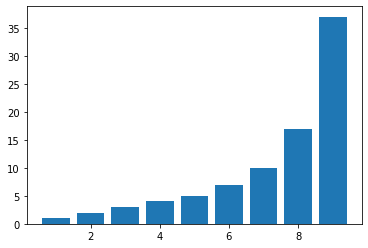

In [25]:
plt.bar(range(1, 10), y)

In [26]:
spark.sql(
    """
    SELECT
        year(from_unixtime(timestamp)) y,
        month(from_unixtime(timestamp)) n,
        COUNT(*) cnt
    FROM raw_tags
    GROUP BY 1,2
    ORDER BY 1,2
    """
).toPandas()

,y,n,cnt
0,NaN,NaN,2
1,2005.0,12.0,29
2,2006.0,1.0,8260
3,2006.0,2.0,5566
4,2006.0,3.0,2668
...,...,...,...
150,2018.0,5.0,158921
151,2018.0,6.0,77817
152,2018.0,7.0,22624
153,2018.0,8.0,15992
